In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import f1_score, confusion_matrix,  ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer

from skopt import BayesSearchCV

In [2]:
df = pd.read_csv("../Data/WithLastEvent.csv")
df.head()

,level_0,type_id,type_name_x,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,match_id,...,pass_type_id,pass_type_name,pass_body_part_id,pass_body_part_name,pass_end_location_x,pass_end_location_y,location_x,location_y,idx,type_name_y
0,4,30,Pass,969,Birmingham City WFC,9,From Kick Off,969,Birmingham City WFC,2275050,...,65.0,Kick Off,40.0,Right Foot,53.9,39.6,61.0,40.1,11,Miscontrol
1,8,30,Pass,969,Birmingham City WFC,9,From Kick Off,969,Birmingham City WFC,2275050,...,NaN,NaN,40.0,Right Foot,118.4,72.9,52.8,42.7,11,Miscontrol
2,12,30,Pass,974,Reading WFC,7,From Goal Kick,974,Reading WFC,2275050,...,63.0,Goal Kick,38.0,Left Foot,13.4,54.2,6.0,44.0,31,Duel
3,16,30,Pass,974,Reading WFC,7,From Goal Kick,974,Reading WFC,2275050,...,NaN,NaN,40.0,Right Foot,62.0,60.2,39.6,58.2,31,Duel
4,23,30,Pass,974,Reading WFC,7,From Goal Kick,969,Birmingham City WFC,2275050,...,NaN,NaN,38.0,Left Foot,69.9,13.3,35.8,9.9,31,Duel


In [3]:
# remove ID columns
non_id = []
for col in df.columns:
    if ("id" not in col) and (col != "idx") and (col != "level_0"):
        non_id.append(col)
        
failure = ["Miscontrol", "Dispossessed", "Interception", "Error", "Own Goal For", "Bad Behaviour"]
failure = np.array(failure)
        
def convert_to_angle(angle):
    
    factor = 180 / math.pi
    return angle * factor

def isFailure(event):
    
    if event in failure:
        return False
    
    return True

In [4]:
df = df[non_id]
df["pass_angle"] = df["pass_angle"].apply(convert_to_angle)
df["type_name_y"] = df["type_name_y"].apply(isFailure)
df = df.drop(columns = ["pass_recipient_name", "pass_type_name", "pass_body_part_name", "timestamp"])

df.head()

,type_name_x,possession_team_name,play_pattern_name,team_name,index,period,minute,second,possession,pass_length,pass_angle,pass_height_name,pass_end_location_x,pass_end_location_y,location_x,location_y,type_name_y
0,Pass,Birmingham City WFC,From Kick Off,Birmingham City WFC,5,1,0,0,2,7.117584,-175.971737,Ground Pass,53.9,39.6,61.0,40.1,False
1,Pass,Birmingham City WFC,From Kick Off,Birmingham City WFC,9,1,0,2,2,72.217730,24.719728,High Pass,118.4,72.9,52.8,42.7,False
2,Pass,Reading WFC,From Goal Kick,Reading WFC,13,1,1,0,3,12.601587,54.039483,Ground Pass,13.4,54.2,6.0,44.0,True
3,Pass,Reading WFC,From Goal Kick,Reading WFC,17,1,1,7,3,22.489109,5.102165,Ground Pass,62.0,60.2,39.6,58.2,True
4,Pass,Reading WFC,From Goal Kick,Birmingham City WFC,24,1,1,11,3,34.269080,5.693957,High Pass,69.9,13.3,35.8,9.9,True


In [5]:
x = df.drop(columns = ["type_name_y"])
y = df["type_name_y"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
print(x_train.shape, ",", x_test.shape)

(768658, 16) , (329425, 16)


In [6]:
categorical_columns = x.dtypes[x.dtypes == "object"].index.tolist()
numerical_columns = x.dtypes[x.dtypes != "object"].index.tolist()

In [7]:
num_pl = StandardScaler()
cat_pl = OneHotEncoder()

col_tr = ColumnTransformer([("categorical", cat_pl, categorical_columns),
                            ("numerical", num_pl, numerical_columns)])

x_train_tr = col_tr.fit_transform(x_train)
x_test_tr = col_tr.fit_transform(x_test)

In [8]:
model = DecisionTreeClassifier()
model = model.fit(x_train_tr, y_train)

In [9]:
preds = model.predict(x_test_tr)
bool_arr = (preds == y_test)
bool_arr.mean()

0.9184063140320256

In [10]:
f1 = f1_score(y_test, preds)
f1

0.9563033324825604

In [50]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import det_curve, DetCurveDisplay

from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

# y_prob = model.predict_proba(x_test_tr)[:, 1]
# prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
# disp = CalibrationDisplay(prob_true, prob_pred, y_prob)

# disp.plot()

# fpr, fnr, _ = det_curve(y_test, preds)
# display = DetCurveDisplay(fpr=fpr, fnr=fnr, estimator_name="dtc")
# display.plot()

# precision, recall, _ = precision_recall_curve(y_test, preds)
# disp = PrecisionRecallDisplay(precision=precision, recall=recall)
# disp.plot()

# cm = confusion_matrix(y_test, preds)
# cm

compare = pd.DataFrame({"Actual":y_test, "Predict":preds})

compare["Success"] = compare["Actual"] == compare["Predict"]

fp = compare.loc[(compare["Actual"] == False) & (compare["Predict"] == True)].shape[0]
tp = compare.loc[(compare["Actual"] == True) & (compare["Predict"] == True)].shape[0]

fn = compare.loc[(compare["Actual"] == True) & (compare["Predict"] == False)].shape[0]
tn = compare.loc[(compare["Actual"] == False) & (compare["Predict"] == False)].shape[0]

confusion_matrix = np.array([[tp, fn],[fp, tn]])

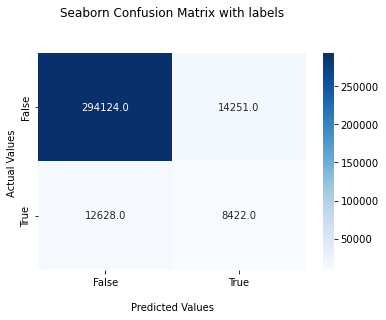

In [53]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix, annot = True, cmap='Blues', fmt=".1f")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [13]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [15]:
params = {
    'min_samples_split':[2,3,5,7],
    'min_samples_leaf':[2,3,5,7],
    'max_depth':[4,5,6,7,8]}

optimizer = BayesSearchCV(DecisionTreeClassifier(), params)
optimizer = optimizer.fit(x_train_tr, y_train)

In [20]:
opt_preds = optimizer.predict(x_test_tr)
opt_acc = (opt_preds == y_test).mean()
opt_acc

0.9363284510890187

In [23]:
optimizer.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'fit_params': None,
 'iid': 'deprecated',
 'n_iter': 50,
 'n_jobs': 1,
 'n_points': 1,
 'optimizer_kwargs': None,
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'search_spaces': {'min_samples_split': [2, 3, 5, 7],
  'min_samples_leaf': [2, 3, 5, 7],
  'max_depth': [4, 5, 6, 7, 8]},
 'verbose': 0}